In [3]:
# preliminaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats
import netCDF4
import xarray as xr
import seaborn as sns
import pickle
import torch

from _pf_data import *
from _lstm import *

## UA SWE data

In [8]:
# LAT AND LON VALUES
model = xr.open_dataset('/home/mcburns/UA_SWE_data/4km_SWE_Depth_WY2000_v01.nc')
lat_values = model['lat'].values
lon_values = model['lon'].values

In [3]:
# GET TESTING DATA 
test_sites = pd.read_csv('/home/mcburns/national_lstm/national_test_sites.txt', sep=' ',header=None)
test_sites.columns = ['site_id', 'site_name', 'site_type', 'agency', 'state','first_date_data_available', 'last_date_data_available', 'record_count',
                     'latitude', 'longitude', 'bins','first_wy_date', 'last_wy_date']

test_years = pd.read_csv('/home/mcburns/national_lstm/national_test_years.txt', sep=' ',header=None)
test_years.columns = ['site_id', 'year', 'train']

base_pfclm = '/home/mcburns/pfclm/output/'

RMSE: 101.87
normal RMSE: 0.25
NSE: 0.51
R2: 0.51
Spearman's rho: 0.86
delta peak SWE: -135.56
normal delta peak SWE: -0.34
delta days: -17.26


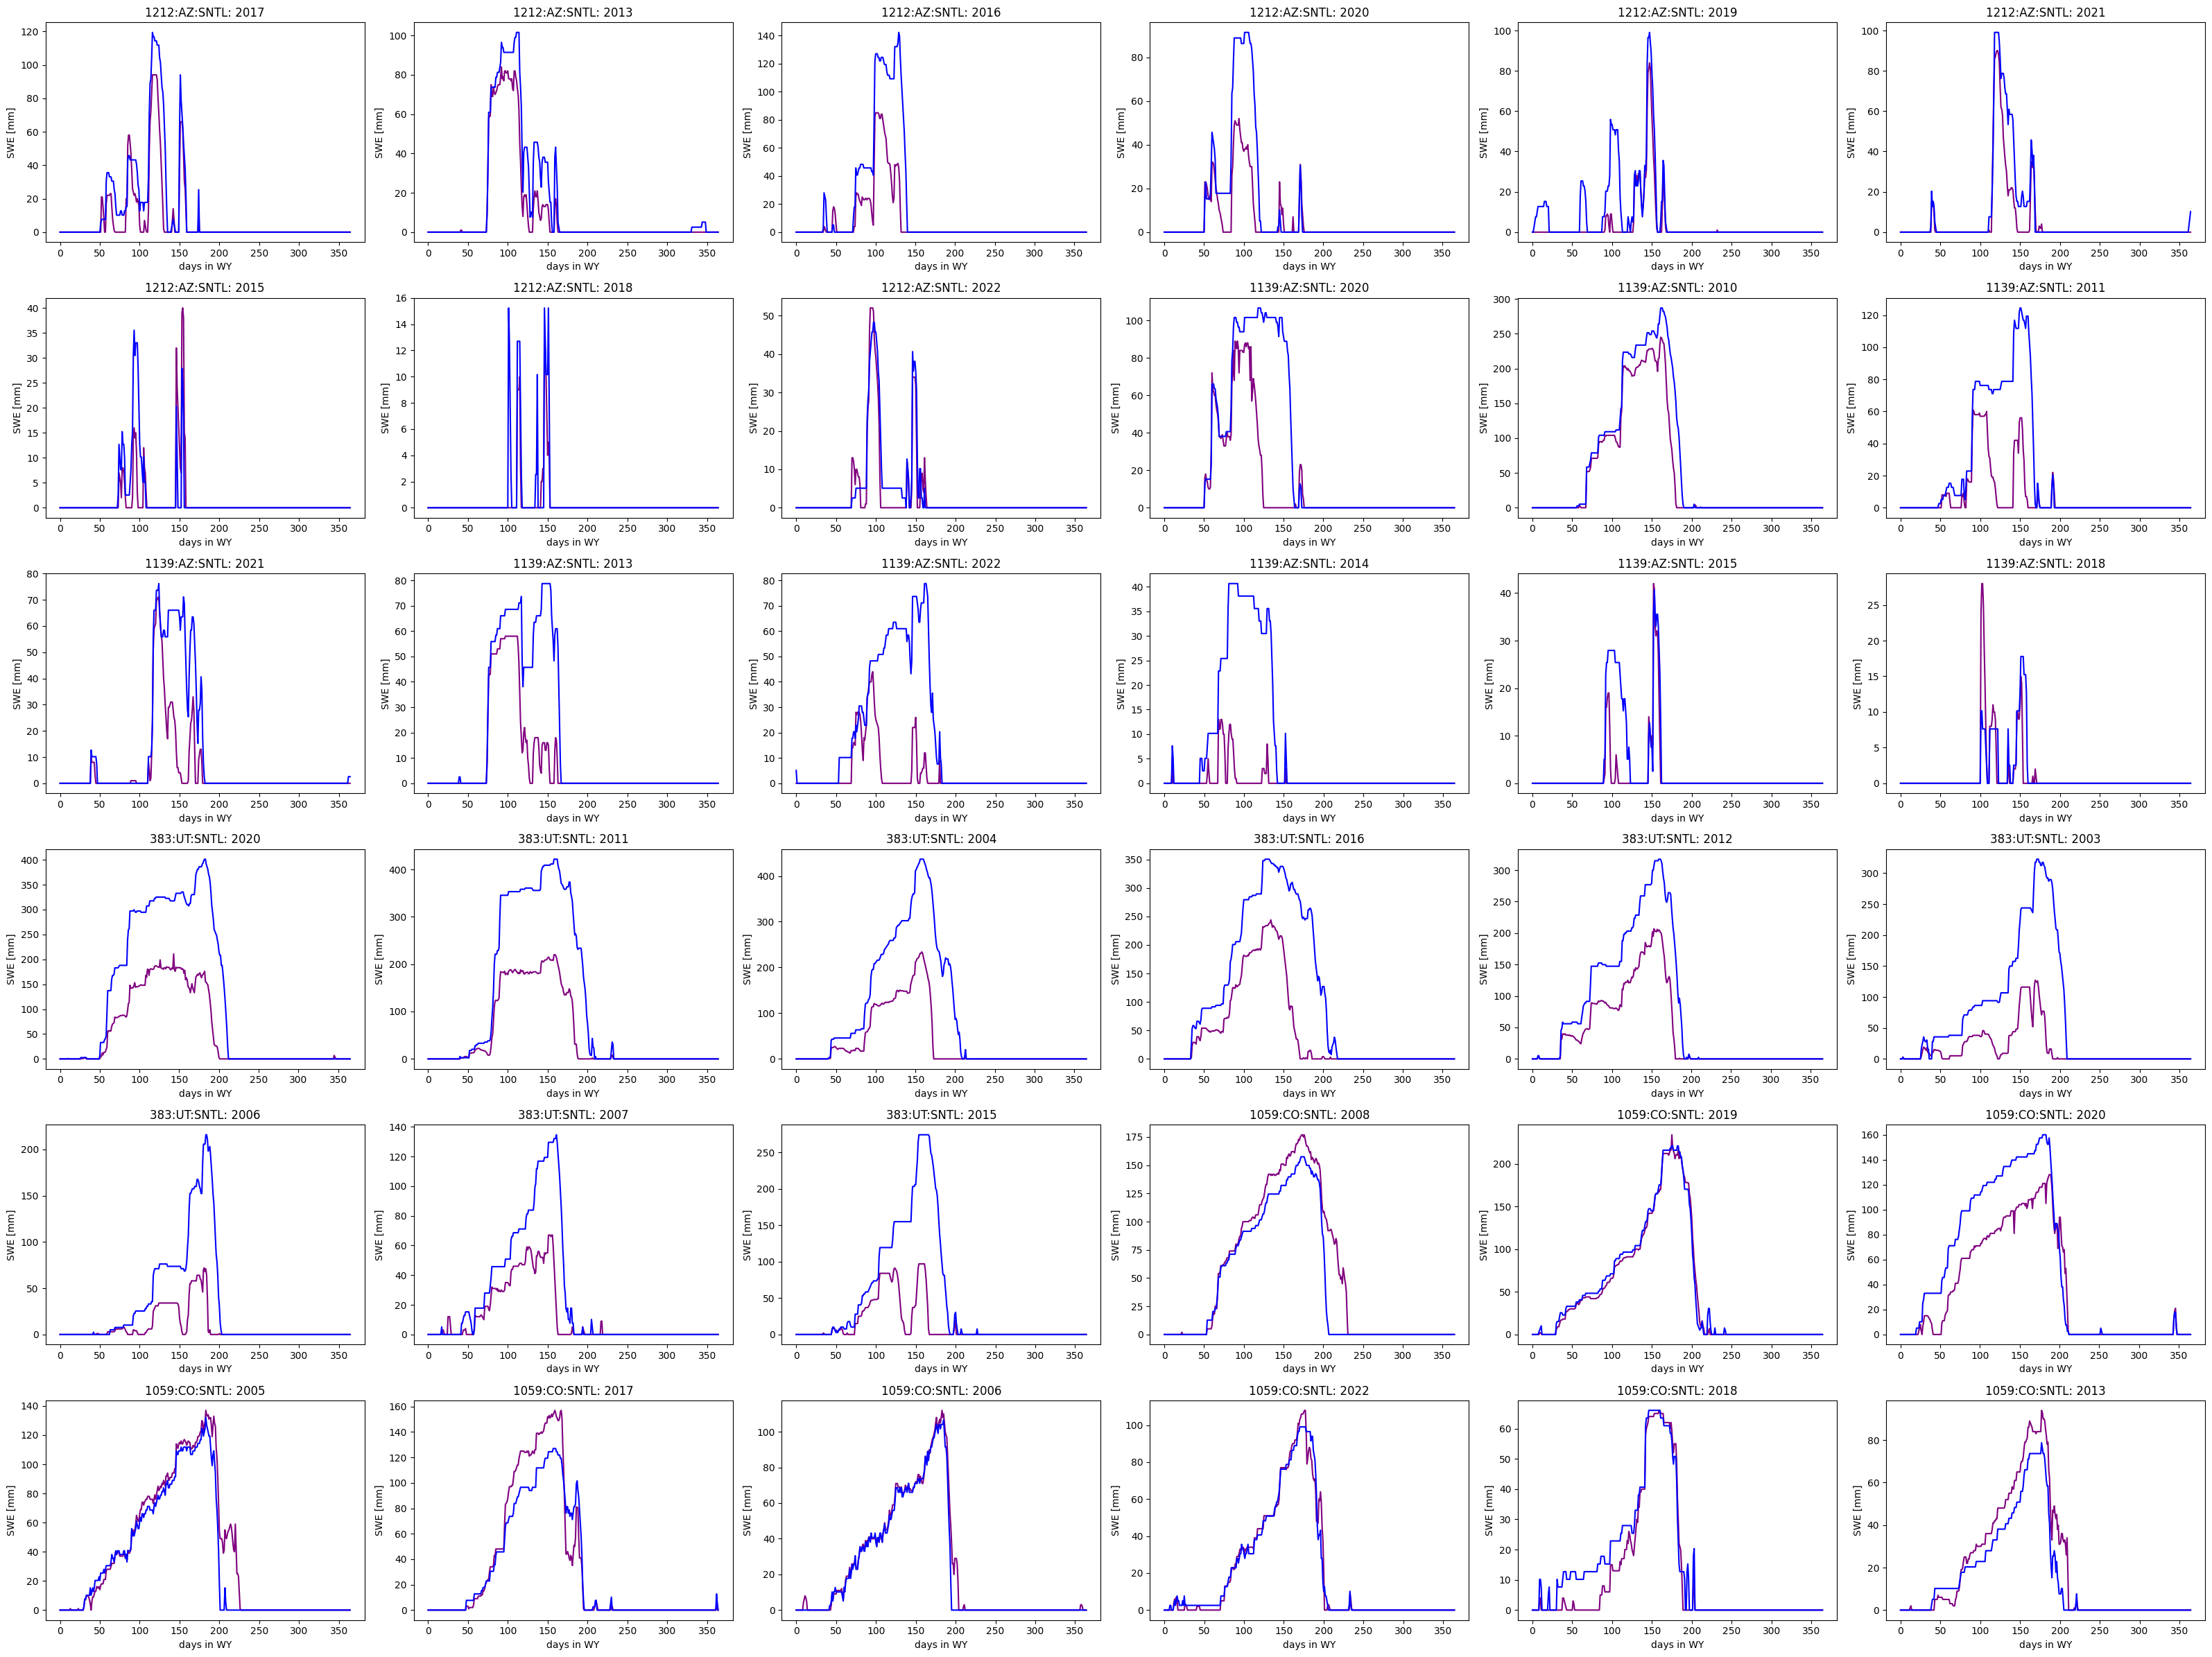

In [22]:
# ANALYZE MODEL OUTPUT
plt.figure(figsize=(32,24))

total_statistics = pd.DataFrame(columns=['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak', 'normal delta peak', 'delta days'])

for i in range(len(test_sites)):
    # get data about each site
    lat = test_sites['latitude'][i]
    lon = test_sites['longitude'][i]
    site_id = test_sites['site_id'][i]

    # transform lat & lon coordinates
    # assumes that the coordinate is the bottom right corner of the box
    # assumes that there is no coordinates higher than 49.92
    for j in np.arange(1, len(lat_values)):
        l_current = lat_values[j]
        if (lat <= l_current): #and (lat > l_last):
            lat_coord = lat_values[j-1]      #i-1
            break
    for j in np.arange(1, len(lon_values)):
        l_last = lon_values[j-1]
        l_current = lon_values[j]
        if (lat >= l_last) and (lon < l_current):
            lon_coord = lon_values[j-1]
            break

    # get data & model predictions for each year
    years = test_years[test_years['site_id'] == site_id].reset_index().drop(columns=['index'])
    for j in range(len(years)):
        year = years['year'][j]
        model = xr.open_dataset('/home/mcburns/UA_SWE_data/4km_SWE_Depth_WY'+str(year)+'_v01.nc')
        swe_ua = model.sel(lat=lat_coord, lon=lon_coord)['SWE'].values

        # read actual SWE
        swe_actual = pd.read_csv(os.path.join(base_pfclm + site_id+'/'+str(year), site_id+'_'+str(year)+'_swe.txt'), 
                                 sep=' ',header=None,index_col=False)
        swe_actual.columns = ['date', 'swe']
        swe_actual['swe'] =  swe_actual['swe'].interpolate(method='linear', limit_direction='both')

        # drop leap day
        # if len(swe_actual) == 366:
        #     swe_actual = swe_actual.drop(60).reset_index()
        #     swe_ua = swe_ua.drop(60).reset_index()

        # analyze statistics
        single_statistics = analyze_results(swe_ua, swe_actual, site_id, year)

        total_statistics.loc[len(total_statistics)] = single_statistics.loc[0]

        if (int(i*9+j) < 36):
            plt.subplot(6, 6, int(i*9+j)+1)
            # blue is actual, purple is predicted
            plt.plot(swe_ua, label='UA predicted swe', c='purple')
            plt.plot(swe_actual['swe'], label='actual swe', c='blue')
            plt.title(site_id + ': '+ str(year))
            plt.xlabel('days in WY')
            plt.ylabel('SWE [mm]')
    
    plt.tight_layout()

## PRINT STATISTICS ##
print(f"RMSE: {np.mean(total_statistics['rmse']):.2f}")
print(f"normal RMSE: {np.mean(total_statistics['normal rmse']):.2f}")
print(f"NSE: {np.mean(total_statistics['nse']):.2f}")
print(f"R2: {np.mean(total_statistics['r2']):.2f}")
print(f"Spearman's rho: {np.mean(total_statistics['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.mean(total_statistics['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.mean(total_statistics['normal delta peak']):.2f}")
print(f"delta days: {np.mean(total_statistics['delta days']):.2f}")

In [4]:
#total_statistics.to_csv('/home/mcburns/UA_SWE_data/national_statistics.txt',sep=' ',header=None, index=False, index_label=False)
total_statistics = pd.read_csv('/home/mcburns/UA_SWE_data/national_statistics.txt',sep=' ',header=None)
total_statistics.columns = ['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak', 'normal delta peak', 'delta days']

## get data from ParFlow

oops


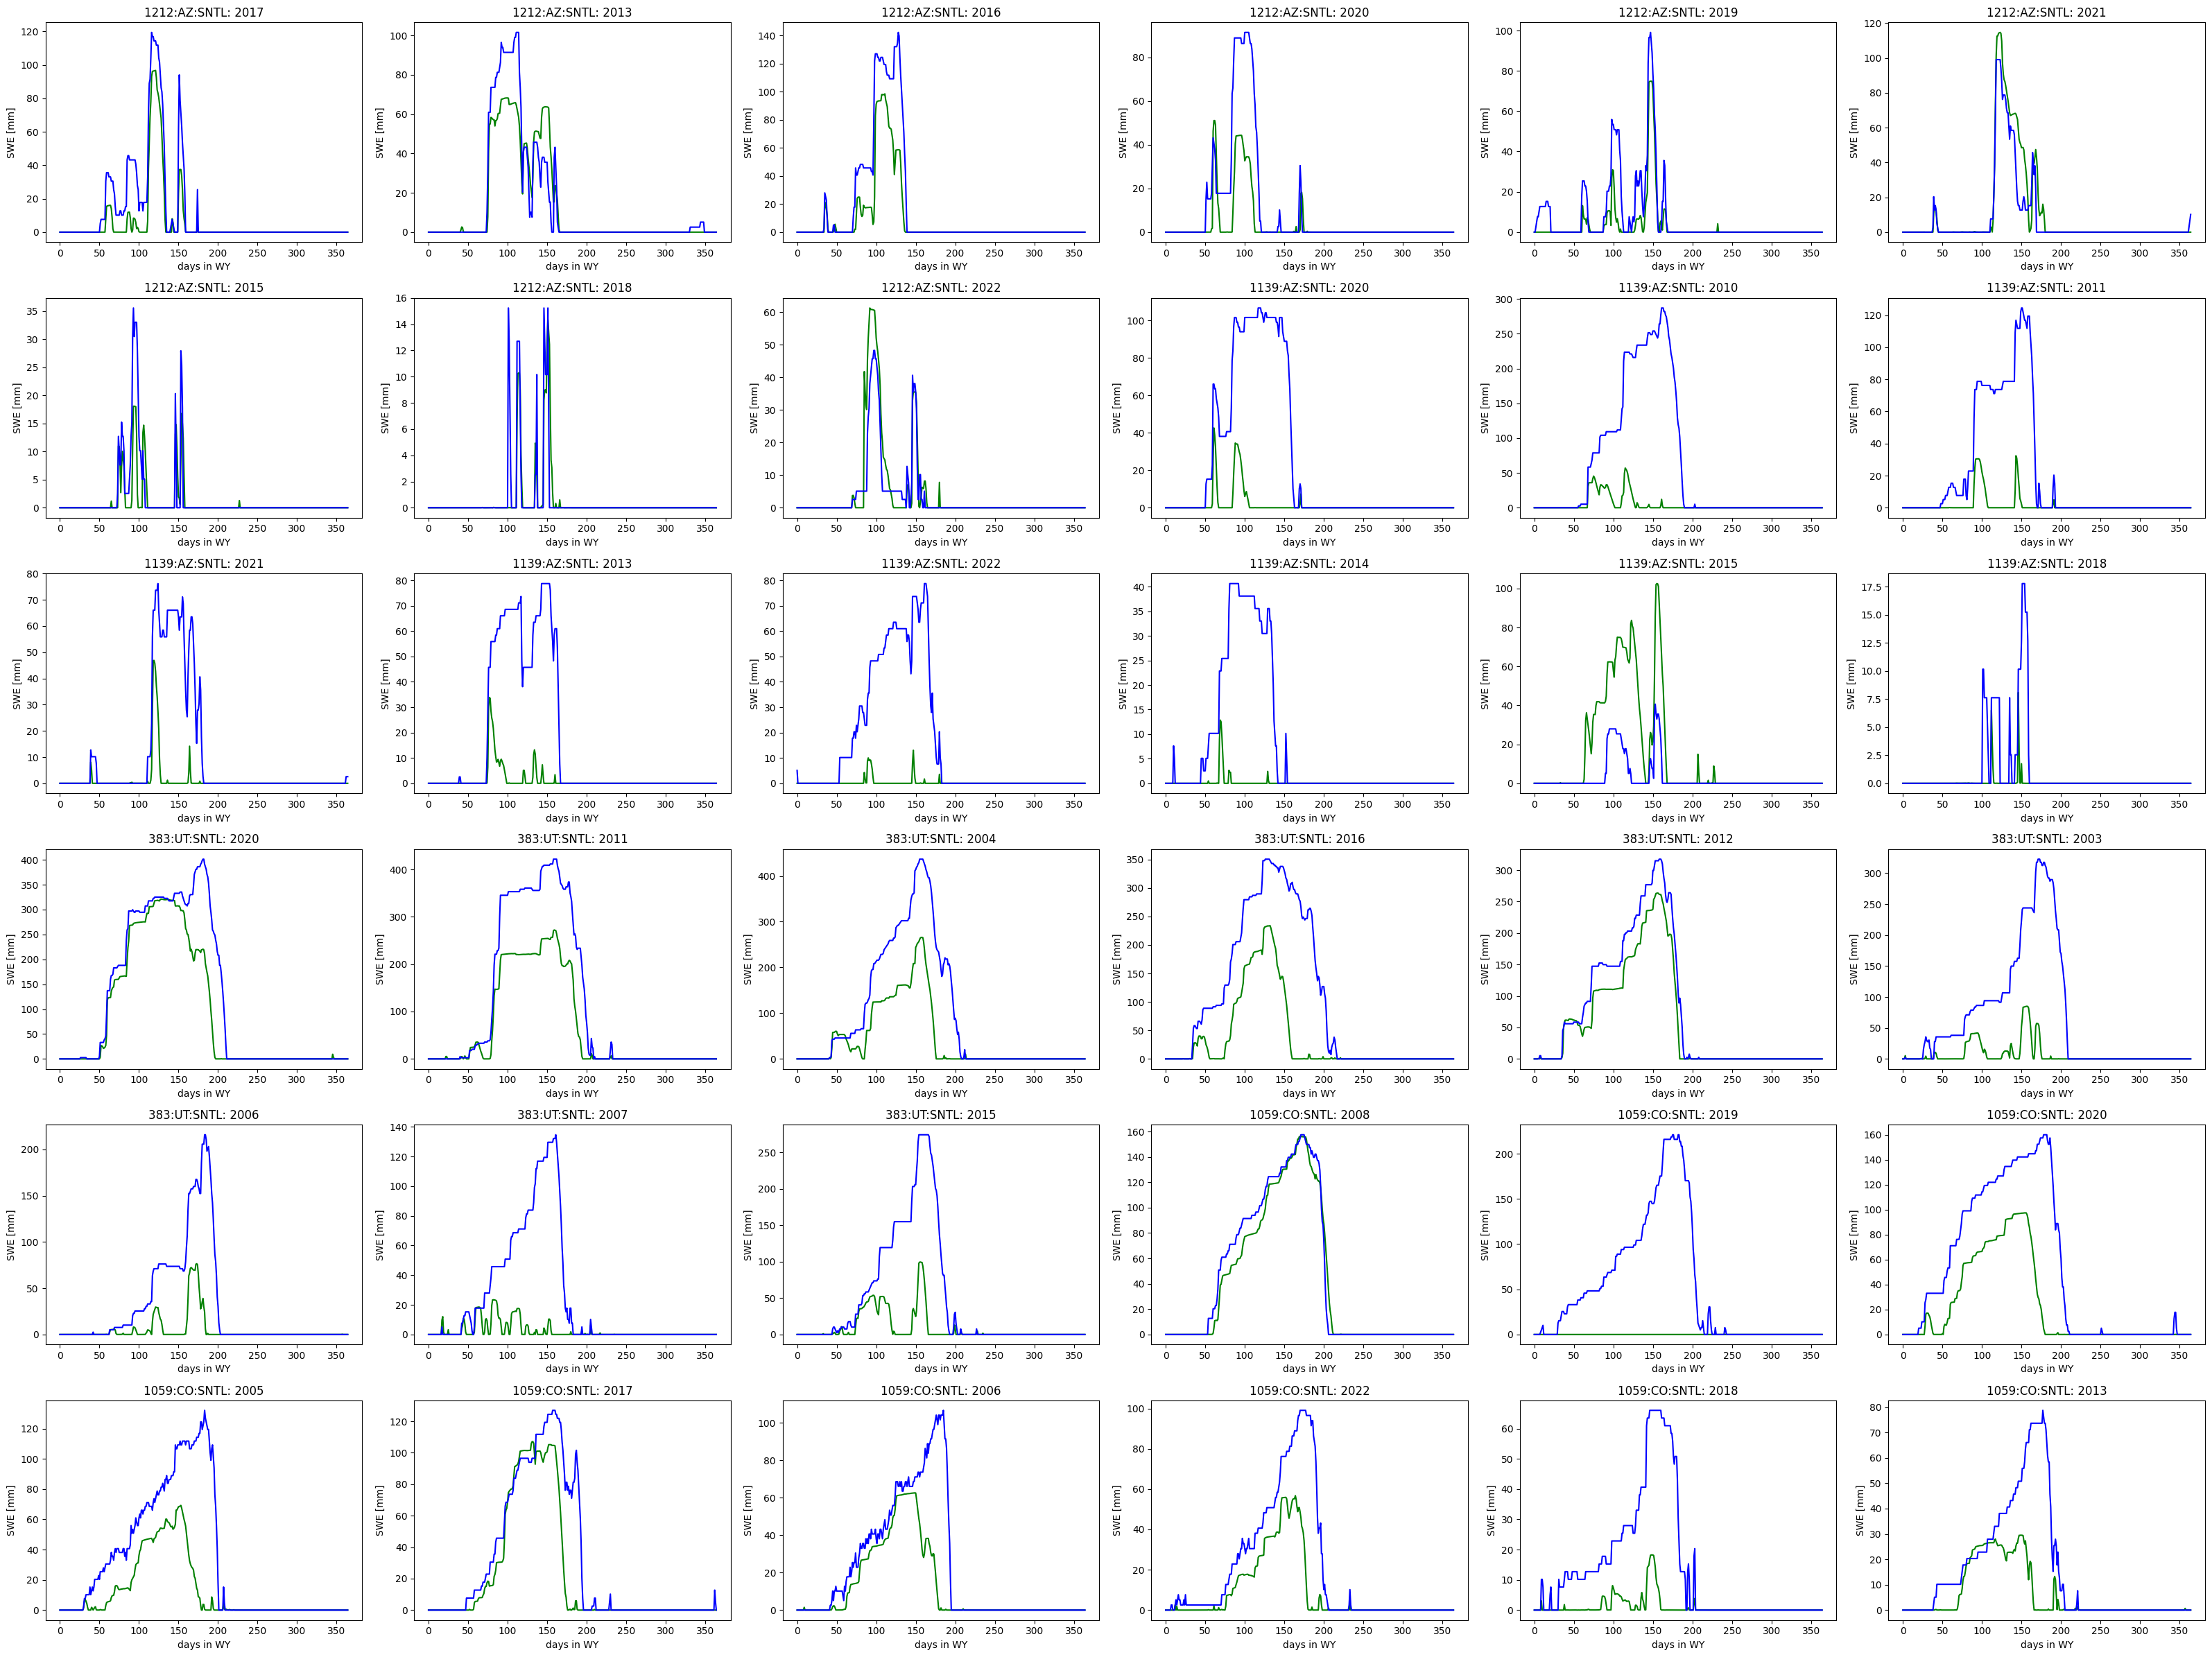

In [7]:
# # GET TESTING DATA
data_test = pd.read_csv('/home/mcburns/national_lstm/national_test_years.txt', sep=' ',header=None)
data_test.columns = ['site_id',	'year',	'train']

plt.figure(figsize=(32,24))
#plt.figure(figsize=(16,10))

total_statistics_pf = pd.DataFrame(columns=['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak', 'normal delta peak', 'delta days'])

# GET PARFLOW RESULTS FOR EACH SITE
for j in range(0, len(data_test)):
    site_id = data_test['site_id'][j]
    year = data_test['year'][j]
    start_date = str(year-1) + '-10-01'
    end_date = str(year) + '-09-30'

    try:
        swe_clm, swe_actual = prod_swe(site_id, year)
        single_statistics = analyze_results(swe_clm['swe'], swe_actual, site_id, year)
    
        total_statistics_pf.loc[len(total_statistics_pf)] = single_statistics.loc[0]
        
        # for regional/national model:
        if (j < 36):
            plt.subplot(6, 6, j+1)
            # blue is actual, green is predicted
            plt.plot(swe_clm, label='predicted swe', c='green')
            plt.plot(swe_actual['swe'], label='actual swe', c='blue')
            plt.title(site_id + ': '+ str(year))
            plt.xlabel('days in WY')
            plt.ylabel('SWE [mm]')
    except:
        print('oops')

plt.tight_layout()

## PRINT STATISTICS ##
print(f"RMSE: {np.mean(total_statistics_pf['rmse']):.2f}")
print(f"normal RMSE: {np.mean(total_statistics_pf['normal rmse']):.2f}")
print(f"NSE: {np.mean(total_statistics_pf['nse']):.2f}")
print(f"R2: {np.mean(total_statistics_pf['r2']):.2f}")
print(f"Spearman's rho: {np.mean(total_statistics_pf['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.mean(total_statistics_pf['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.mean(total_statistics_pf['normal delta peak']):.2f}")
print(f"delta days: {np.mean(total_statistics_pf['delta days']):.2f}")

In [5]:
total_statistics_pf = pd.read_csv('/home/mcburns/pfclm/national_statistics.txt',sep=' ',header=None)
total_statistics_pf.columns = ['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak', 'normal delta peak', 'delta days']

## LSTM 

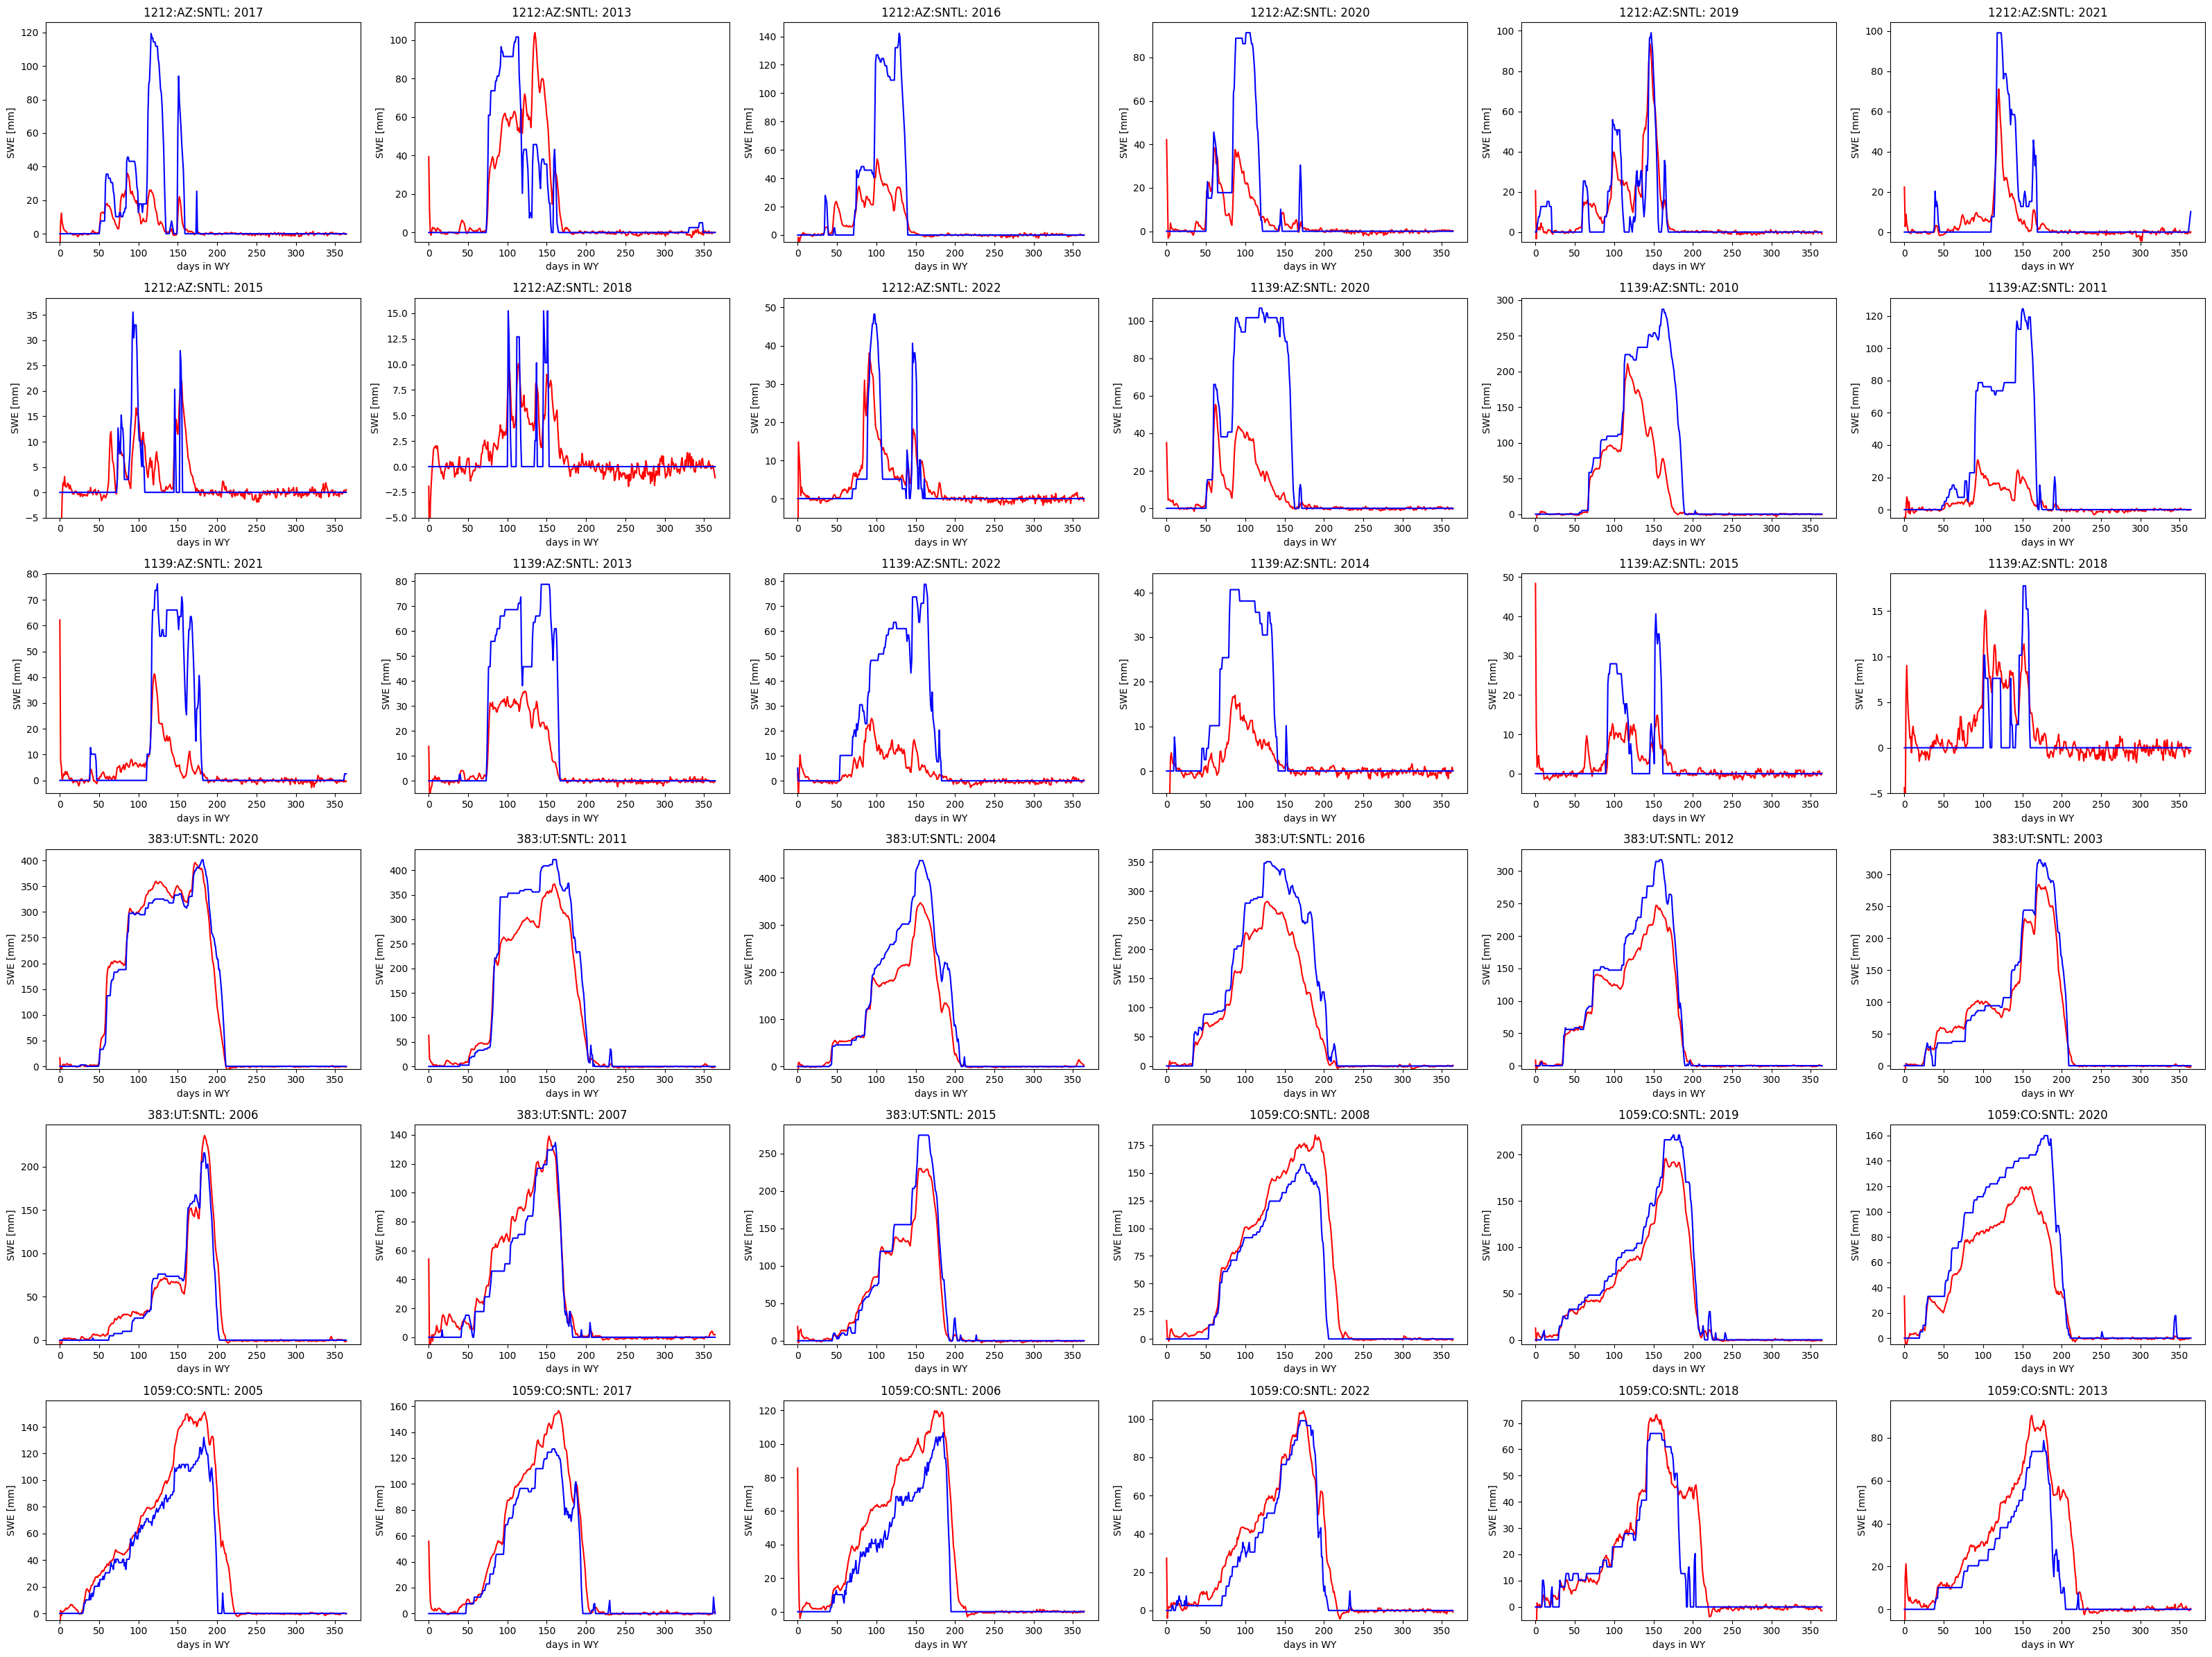

In [28]:
# LSTM - ignore the names they're random
# ['l5_162','l3_200','l5_200']
# MAKE THIS THE MEAN OF 3 BEST RUNS
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

data_test = pd.read_csv('/home/mcburns/national_lstm/national_test_years.txt', sep=' ',header=None)
data_test.columns = ['site_id',	'year',	'train']

plt.figure(figsize=(32,24))

#total_statistics_lstm = pd.DataFrame(columns=['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak', 'normal delta peak', 'delta days'])

# GET MODEL DATA 
lstm_1 = torch.load('/home/mcburns/national_lstm/output/l5_162_lstm.pt', map_location = DEVICE)
lstm_2 = torch.load('/home/mcburns/national_lstm/output/l3_200_lstm.pt', map_location = DEVICE)
lstm_3 = torch.load('/home/mcburns/national_lstm/output/l5_200_lstm.pt', map_location = DEVICE)
test_swe_1 = torch.load('/home/mcburns/national_lstm/output/l5_162_test_swe.pt')
test_non_swe_1 = torch.load('/home/mcburns/national_lstm/output/l5_162_test_non_swe.pt')
test_non_swe_2 = torch.load('/home/mcburns/national_lstm/output/l3_200_test_non_swe.pt')
test_non_swe_3 = torch.load('/home/mcburns/national_lstm/output/l5_200_test_non_swe.pt')
with open('/home/mcburns/national_lstm/output/l5_162_normalize.pkl', 'rb') as file:  
    l_normalize = pickle.load(file)
scaler_swe_1 = l_normalize[0]
with open('/home/mcburns/national_lstm/output/l3_200_normalize.pkl', 'rb') as file:  
    l_normalize = pickle.load(file)
scaler_swe_2 = l_normalize[0]
with open('/home/mcburns/national_lstm/output/l5_200_normalize.pkl', 'rb') as file:  
    l_normalize = pickle.load(file)
scaler_swe_3 = l_normalize[0]

# GET RESULTS FOR EACH SITE
for i in range(0, len(data_test)):
    site_id = data_test['site_id'][i]
    year = data_test['year'][i]
    start_date = str(year-1) + '-10-01'
    end_date = str(year) + '-09-30'

    test_swe_tensors_1 = test_swe_1[i]
    test_non_swe_tensors_1 = torch.reshape(test_non_swe_1[i], (test_non_swe_1[i].shape[0], 1, 
                                                                       test_non_swe_1[i].shape[1])).to(DEVICE)
    swe_pred_1 = lstm_1(test_non_swe_tensors_1)
    swe_pred_1 = scaler_swe_1.inverse_transform(swe_pred_1.cpu().detach().numpy().reshape(-1,1))
    
    test_non_swe_tensors_2 = torch.reshape(test_non_swe_2[i], (test_non_swe_2[i].shape[0], 1, 
                                                                       test_non_swe_2[i].shape[1])).to(DEVICE)
    swe_pred_2 = lstm_2(test_non_swe_tensors_2)
    swe_pred_2 = scaler_swe_2.inverse_transform(swe_pred_2.cpu().detach().numpy().reshape(-1,1))
    
    test_non_swe_tensors_3 = torch.reshape(test_non_swe_3[i], (test_non_swe_3[i].shape[0], 1, 
                                                                       test_non_swe_3[i].shape[1])).to(DEVICE)
    swe_pred_3 = lstm_3(test_non_swe_tensors_3)
    swe_pred_3 = scaler_swe_3.inverse_transform(swe_pred_3.cpu().detach().numpy().reshape(-1,1))
    test_swe = scaler_swe_1.inverse_transform(test_swe_tensors_1.cpu().detach().numpy().reshape(-1,1))
    
    swe_pred = np.mean([swe_pred_1,swe_pred_2,swe_pred_3], axis=0)

    # for regional/national model:
    if (i < 36):
        plt.subplot(6, 6, i+1)
        # blue is actual, green is predicted
        plt.plot(swe_pred, label='LSTM', c='red')
        plt.plot(test_swe, label='SNOTEL', c='blue')
        plt.title(site_id + ': '+ str(year))
        plt.xlabel('days in WY')
        plt.ylabel('SWE [mm]')
        plt.ylim(bottom=-5)

plt.tight_layout()

## plots

[Text(0.5, 1.0, 'Comparison with Other Models'),
 Text(0.5, 23.52222222222222, 'Model Name')]

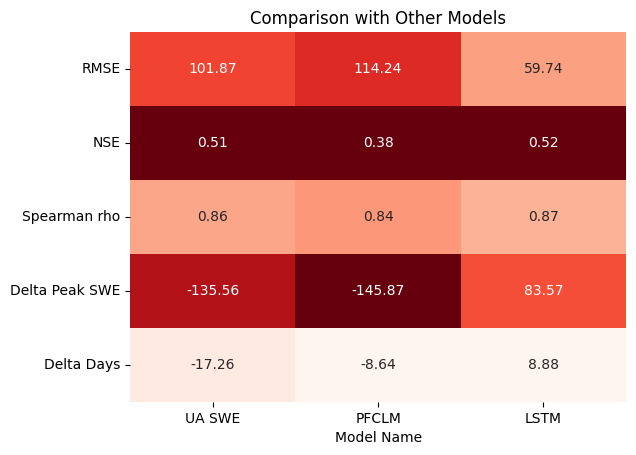

In [20]:
## HEATMAP ##
model_statistics = pd.DataFrame(columns=['run name','rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak', 'normal delta peak', 'delta days'])
# UA SWE
model_statistics.loc[len(model_statistics)] = ['UA SWE', np.mean(total_statistics['rmse']), np.mean(total_statistics['normal rmse']),
                                               np.mean(total_statistics['nse']), np.mean(total_statistics['r2']),
                                               np.mean(total_statistics['spearman_rho']), np.mean((total_statistics['delta peak'])), 
                                               np.mean((total_statistics['normal delta peak'])), np.mean(total_statistics['delta days'])]
# PF CLM
model_statistics.loc[len(model_statistics)] = ['PFCLM', np.mean(total_statistics_pf['rmse']), np.mean(total_statistics_pf['normal rmse']),
                                               np.mean(total_statistics_pf['nse']), np.mean(total_statistics_pf['r2']),
                                               np.mean(total_statistics_pf['spearman_rho']), np.mean((total_statistics_pf['delta peak'])), 
                                               np.mean((total_statistics_pf['normal delta peak'])), np.mean(total_statistics_pf['delta days'])]
# LSTM model mean
models = ['l5_162','l3_200','l5_200']
total_statistics_models = get_model_metrics(models,'national')
model_statistics.loc[len(model_statistics)] = ['LSTM mean', np.mean(total_statistics_models['rmse']), np.mean(total_statistics_models['normal rmse']),
                                               np.mean(total_statistics_models['nse']), np.mean(total_statistics_models['r2']),
                                               np.mean(total_statistics_models['spearman_rho']), np.mean((total_statistics_models['delta peak'])), 
                                               np.mean((total_statistics_models['normal delta peak'])), 
                                               np.mean(total_statistics_models['delta days'])]
model_statistics['normal delta days'] = model_statistics['delta days']/365

# adjust data
model_statistics = model_statistics.set_index('run name')
model_statistics_plot = model_statistics.drop(columns=['r2','rmse','delta peak','delta days'])
model_statistics = model_statistics.drop(columns=['r2','normal rmse','normal delta peak','normal delta days'])

# adjust colors
model_statistics_plot['nse'] = 1-model_statistics_plot['nse']
model_statistics_plot['spearman_rho'] = 1-model_statistics_plot['spearman_rho']
model_statistics_plot = np.abs(model_statistics_plot)
model_statistics_plot = model_statistics_plot.transpose()
model_statistics = model_statistics.transpose()

# plot
ax = sns.heatmap(model_statistics_plot, annot=model_statistics, fmt=".2f", cmap='Reds', vmax=0.4, cbar=False,
                 yticklabels = ['RMSE','NSE','Spearman rho','Delta Peak SWE','Delta Days'], xticklabels=['UA SWE','PFCLM','LSTM'])
ax.set(title='Comparison with Other Models', xlabel='Model Name')

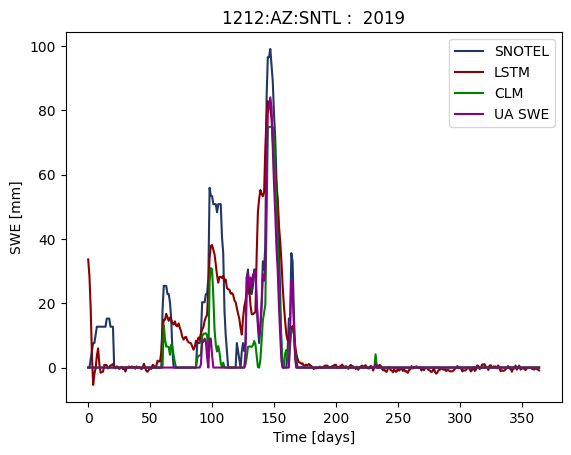

In [18]:
## PLOT FOR REPRESENTATIVE YEARS ##
site_id = '1212:AZ:SNTL'
year = 2019

test_metadata = pd.read_csv('/home/mcburns/national_lstm/output/l5_200_test_metadata.csv', sep=' ')
i = test_metadata.loc[(test_metadata['site_id'] == site_id) & (test_metadata['year'] == year)].index[0]

lat = test_metadata['latitude'][i]
lon = test_metadata['longitude'][i]

## UA SWE ##
# transform lat & lon coordinates
for j in np.arange(1, len(lat_values)):
    l_current = lat_values[j]
    if (lat <= l_current): #and (lat > l_last):
        lat_coord = lat_values[j-1]      #i-1
        break
for j in np.arange(1, len(lon_values)):
    l_last = lon_values[j-1]
    l_current = lon_values[j]
    if (lat >= l_last) and (lon < l_current):
        lon_coord = lon_values[j-1]
        break

model = xr.open_dataset('/home/mcburns/UA_SWE_data/4km_SWE_Depth_WY'+str(year)+'_v01.nc')
swe_ua = model.sel(lat=lat_coord, lon=lon_coord)['SWE'].values

## PFCLM AND ACTUAL SWE ##
swe_clm, swe_actual = prod_swe(site_id, year)

## LSTM - MEAN OF 3 BEST MODELS ##
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

lstm_1 = torch.load('/home/mcburns/national_lstm/output/l5_162_lstm.pt', map_location = DEVICE)
lstm_2 = torch.load('/home/mcburns/national_lstm/output/l3_200_lstm.pt', map_location = DEVICE)
lstm_3 = torch.load('/home/mcburns/national_lstm/output/l5_200_lstm.pt', map_location = DEVICE)

test_swe_1 = torch.load('/home/mcburns/national_lstm/output/l5_162_test_swe.pt')
test_non_swe_1 = torch.load('/home/mcburns/national_lstm/output/l5_162_test_non_swe.pt')
test_non_swe_2 = torch.load('/home/mcburns/national_lstm/output/l3_200_test_non_swe.pt')
test_non_swe_3 = torch.load('/home/mcburns/national_lstm/output/l5_200_test_non_swe.pt')
with open('/home/mcburns/national_lstm/output/l5_162_normalize.pkl', 'rb') as file:  
    l_normalize = pickle.load(file)
scaler_swe_1 = l_normalize[0]
with open('/home/mcburns/national_lstm/output/l3_200_normalize.pkl', 'rb') as file:  
    l_normalize = pickle.load(file)
scaler_swe_2 = l_normalize[0]
with open('/home/mcburns/national_lstm/output/l5_200_normalize.pkl', 'rb') as file:  
    l_normalize = pickle.load(file)
scaler_swe_3 = l_normalize[0]

test_swe_tensors_1 = test_swe_1[i]

test_non_swe_tensors_1 = torch.reshape(test_non_swe_1[i], (test_non_swe_1[i].shape[0], 1, 
                                                                   test_non_swe_1[i].shape[1])).to(DEVICE)
swe_pred_1 = lstm_1(test_non_swe_tensors_1)
swe_pred_1 = scaler_swe_1.inverse_transform(swe_pred_1.cpu().detach().numpy().reshape(-1,1))

test_non_swe_tensors_2 = torch.reshape(test_non_swe_2[i], (test_non_swe_2[i].shape[0], 1, 
                                                                   test_non_swe_2[i].shape[1])).to(DEVICE)
swe_pred_2 = lstm_2(test_non_swe_tensors_2)
swe_pred_2 = scaler_swe_2.inverse_transform(swe_pred_2.cpu().detach().numpy().reshape(-1,1))

test_non_swe_tensors_3 = torch.reshape(test_non_swe_3[i], (test_non_swe_3[i].shape[0], 1, 
                                                                   test_non_swe_3[i].shape[1])).to(DEVICE)
swe_pred_3 = lstm_3(test_non_swe_tensors_3)
swe_pred_3 = scaler_swe_3.inverse_transform(swe_pred_3.cpu().detach().numpy().reshape(-1,1))

test_swe = scaler_swe_1.inverse_transform(test_swe_tensors_1.cpu().detach().numpy().reshape(-1,1))

swe_pred = np.mean([swe_pred_1,swe_pred_2,swe_pred_3], axis=0)


## PLOT COMPARISON ##
fig=plt.figure()

plt.plot(swe_actual['swe'], label='SNOTEL',c='#203864') 
plt.plot(swe_pred, label='LSTM',c='darkred')
plt.plot(swe_clm, label='CLM', c='green')
plt.plot(swe_ua, label='UA SWE', c='darkmagenta')
#plt.ylim([-5,110])
plt.xlabel('Time [days]') 
plt.ylabel('SWE [mm]')
plt.title(site_id + ' :  '+str(year))
plt.legend()